base_python env

In [62]:
from IPython import get_ipython
get_ipython().run_line_magic('reset', '-sf') 

import pandas as pd
import numpy as np
import glob
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp, ks_1samp, norm
from statannot import add_stat_annotation
import os
from modules.data_loader import file_extraction, csv_to_xlsx,file_folder_creator
from modules.graphics_handler import histplot_fine_view, boxplot_fine_view


First of all, we need to choose export column in the input tables.
Here, we need Volume(unit) and SurfaceArea (um2). 

## Step 1. Grab .csv files, convert it to .xlsx and upload into dataframe (df).

In [63]:
search_path = 'data/*cell*'
tot_vol_path = 'data/total_vol.xlsx'
save_folder = 'GS_GLT/'

In [64]:
csv_to_xlsx(search_path)

In [65]:
data = file_extraction(search_path)

In [66]:
data.head()

,volume,surface_area,animal_num,exp_group,slice_num,cell_num,protein
id,,,,,,,
1,0.0788,1.4307,1,ctrl,1,1,GLT
2,0.1504,2.5328,1,ctrl,1,1,GLT
3,0.3366,3.3982,1,ctrl,1,1,GLT
4,0.2685,3.8858,1,ctrl,1,1,GLT
5,0.4296,5.0187,1,ctrl,1,1,GLT


We can see descriptive statistics for our data.

In [67]:
data.describe()

,volume,surface_area
count,1.442190e+05,1.442190e+05
mean,9.548748e+00,6.836457e+02
std,3.293242e+03,3.575108e+04
min,3.000000e-03,1.460000e-01
25%,1.683000e-01,2.420300e+00
50%,3.360000e-01,3.875200e+00
75%,5.514000e-01,5.513900e+00
max,1.250592e+06,2.902219e+06


## Step 2. Distribution histograms

In [68]:
CLUST_PROTEIN, CELL_PROTEIN = data['protein'].unique()

In [69]:
data_clust= data[(data['protein']==CLUST_PROTEIN)].copy(deep=True)
data_cell = data[(data['protein']==CELL_PROTEIN)].copy(deep=True)

In [70]:
data_clust.drop(data_clust[data_clust['volume']>1.7].index, inplace=True)
data_clust.drop(data_clust[data_clust['surface_area']>11].index, inplace=True)

In [71]:
file_folder_creator('figs')

'Folder created'

In [72]:
file_folder_creator(f'figs/{save_folder}')

'Folder created'

In [73]:
file_folder_creator('output_table')

'Folder created'

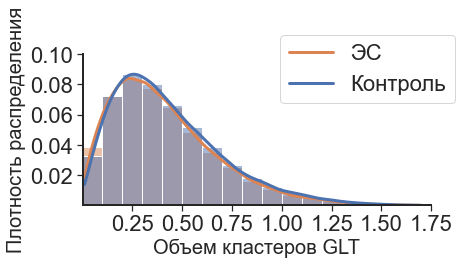

In [74]:
histplot_fine_view(data=data_clust, x='volume',
                    binwidth=0.1, binrange=[0,2], 
                    ytick=0.02, xtick=0.25,
                    ylim=[0.0001, 0.1], xlim=[0.0001, 1.75],
                    ylabel='Плотность распределения', xlabel=f'Объем кластеров {CLUST_PROTEIN}',
                    figname = f'{save_folder}/плотность распределения кластеров {CLUST_PROTEIN} с разным объемом')

In [75]:
ks_1samp(data_clust[data_clust['exp_group']=='ctrl'].loc[:,'volume'], norm.cdf)

KstestResult(statistic=0.5051830219896157, pvalue=0.0)

In [76]:
ks_1samp(data_clust[data_clust['exp_group']=='SE'].loc[:,'volume'], norm.cdf)

KstestResult(statistic=0.5039893563146316, pvalue=0.0)

In [77]:
ks_2samp(data_clust[data_clust['exp_group']=='ctrl'].loc[:,'volume'], 
         data_clust[data_clust['exp_group']=='SE'].loc[:,'volume'])

KstestResult(statistic=0.02932892603038767, pvalue=1.6858631475683623e-23)

Here we observe the difference between GLT volume clusters distributions and the normal one. The difference between the control and the experiment are exists.

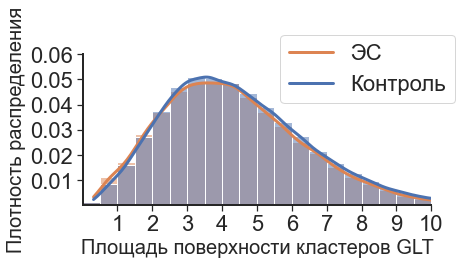

In [78]:
histplot_fine_view(data=data_clust, x='surface_area',
                    binwidth=0.5, binrange=[0,10], 
                    ytick=0.01, xtick=1,
                    ylim=[0.0001, 0.06], xlim=[0.0001, 10],
                    ylabel='Плотность распределения', xlabel=f'Площадь поверхности кластеров {CLUST_PROTEIN}',
                    figname = f'{save_folder}/площадь поверхности клатеров {CLUST_PROTEIN} с разным объемом')


In [79]:
ks_1samp(data_clust[data_clust['exp_group']=='ctrl'].loc[:,'surface_area'], norm.cdf)

KstestResult(statistic=0.886233125486906, pvalue=0.0)

In [80]:
ks_1samp(data_clust[data_clust['exp_group']=='SE'].loc[:,'surface_area'], norm.cdf)

KstestResult(statistic=0.8747511679887847, pvalue=0.0)

In [81]:
ks_2samp(data_clust[data_clust['exp_group']=='ctrl'].loc[:,'surface_area'], 
                  data_clust[data_clust['exp_group']=='SE'].loc[:,'surface_area'])

KstestResult(statistic=0.019520552432212623, pvalue=1.1984869759200329e-10)

GLT clusters surface area of control and experimental group has a distribution that differ from normal. Moreover, they are also distinct between each other.   

We need to calculate surface-to-volume ration to obtain information about clusters shape

In [82]:
data_clust['svr_clust'] = data_clust.loc[:, 'surface_area']/data_clust.loc[:, 'volume']
data_clust.head()

,volume,surface_area,animal_num,exp_group,slice_num,cell_num,protein,svr_clust
id,,,,,,,,
1,0.0788,1.4307,1,ctrl,1,1,GLT,18.156091
2,0.1504,2.5328,1,ctrl,1,1,GLT,16.840426
3,0.3366,3.3982,1,ctrl,1,1,GLT,10.095663
4,0.2685,3.8858,1,ctrl,1,1,GLT,14.472253
5,0.4296,5.0187,1,ctrl,1,1,GLT,11.682263


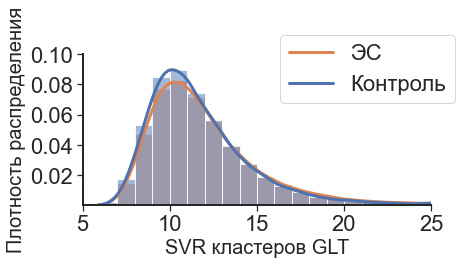

In [83]:
histplot_fine_view(data=data_clust, x='svr_clust',
                    binwidth=1, binrange=[0,30], 
                    ytick=0.02, xtick=5,
                    ylim=[0.0001, 0.1], xlim=[5, 25],
                    ylabel='Плотность распределения', xlabel=f'SVR кластеров {CLUST_PROTEIN}',
                    figname = f'{save_folder}/SVR кластеров {CLUST_PROTEIN} с разным объемом')


In [84]:
ks_1samp(data_clust[data_clust['exp_group']=='ctrl'].loc[:,'svr_clust'], norm.cdf)

KstestResult(statistic=0.9999999980817719, pvalue=0.0)

In [85]:
ks_1samp(data_clust[data_clust['exp_group']=='SE'].loc[:,'svr_clust'], norm.cdf)

KstestResult(statistic=0.9999999996231396, pvalue=0.0)

In [86]:
stat_ks_test, p_ks_test = ks_2samp(data_clust[data_clust['exp_group']=='ctrl'].iloc[:,-1], data_clust[data_clust['exp_group']=='SE'].iloc[:,-1])

print('Statistics=%.3f, p=%.50f' % (stat_ks_test, p_ks_test))

Statistics=0.037, p=0.00000000000000000000000000000000000130436002821362


The curves from the two experimental groups belong to different distributions, which is confirmed by the Kolmagorov-Smirnov test

## Step 3. Hypothesis testing

In [87]:
mask_ctrl_clust = data['exp_group']=='ctrl'
mask_SE_clust= data['exp_group']=='SE'

<AxesSubplot:>

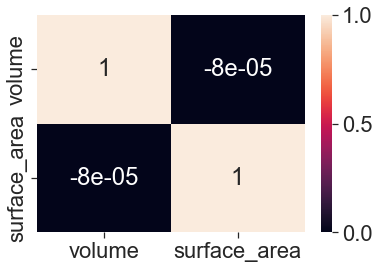

In [88]:
sns.heatmap(data[mask_ctrl_clust].loc[:, ['volume', 'surface_area']].corr(), annot=True)

<AxesSubplot:>

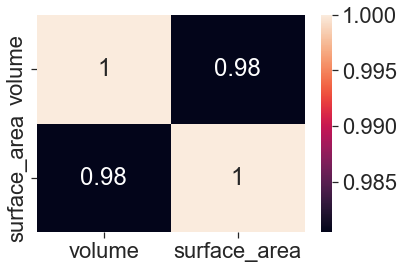

In [89]:
sns.heatmap(data[mask_SE_clust].loc[:, ['volume', 'surface_area']].corr(), annot=True)

We see a positive correlation between the cluster volume and its surface area for the SE group. This means that the larger the volume, the larger the surface area.

### SVR ctrl vs. SE

We want to see the distribution of features in individual cells. For this we use pivot_table

In [90]:
wide_clust = pd.pivot_table(data_clust,
                index = ['animal_num','slice_num','cell_num'],
                columns = ['exp_group'],
                values = ['volume', 'surface_area', 'svr_clust'],
                aggfunc = 'median')  
wide_clust = wide_clust.reindex(columns=[('volume','ctrl'),('volume','SE'), 
                            ('surface_area', 'ctrl'), ('surface_area', 'SE'), 
                            ('svr_clust','ctrl'), ('svr_clust','SE')])
wide_clust.head()


volume         surface_area          svr_clust  \
exp_group                        ctrl      SE         ctrl      SE       ctrl   
animal_num slice_num cell_num                                                   
1          1         1         0.3724  0.2550       4.3333  3.2040  11.585260   
                     2         0.3258  0.3040       3.7909  3.6140  11.593853   
           2         1         0.3724  0.2710       4.1128  3.3670  11.010475   
                     2         0.4082  0.2895       4.3992  3.4855  10.798890   
2          1         1         0.2936  0.3010       3.5407  3.6310  12.125590   

                                          
exp_group                             SE  
animal_num slice_num cell_num             
1          1         1         12.569170  
                     2         11.957143  
           2         1         12.362676  
                     2         12.084979  
2          1         1         11.985281

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

('svr_clust', 'ctrl') v.s. ('svr_clust', 'SE'): Mann-Whitney-Wilcoxon test two-sided, P_val=2.679e-01 U_stat=1.840e+02


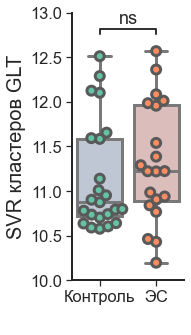

In [91]:
boxplot_fine_view(data=wide_clust.iloc[:, 4:6], 
                    box_pairs=(('svr_clust','ctrl'),('svr_clust','SE')),
                    ylabel=f'SVR кластеров {CLUST_PROTEIN}',
                    ylim=[10, 13], ytick = 0.5,
                    figname = f'{save_folder}/SVR кластеров {CLUST_PROTEIN}')

In [92]:
percentile_svr_clusters = wide_clust.iloc[:, 4:6].quantile([0.25, 0.50 , 0.75])
print(percentile_svr_clusters)

           svr_clust           
exp_group       ctrl         SE
0.25       10.719648  10.890548
0.50       10.874891  11.223198
0.75       11.589557  11.964177


In [93]:
stat_svr_num, p_svr_num = mannwhitneyu(wide_clust.iloc[:, 4].dropna(), wide_clust.iloc[:, 5].dropna())
print('Statistics=%.3f, p=%.8f' % (stat_svr_num, p_svr_num))

Statistics=184.000, p=0.26790919


SVR is not statistically different in control and after ES

### Clusters quantity ctrl vs SE

Add a column with data of the clusters quantity for each cell

In [94]:
wide_clust [[('clust_quantity', 'ctrl'), (('clust_quantity', 'SE'))]] = pd.pivot_table(data_clust,
                                                                                    index = ['animal_num','slice_num','cell_num'],
                                                                                    columns = ['exp_group'],
                                                                                    values = ['volume'],
                                                                                    aggfunc = 'count')
wide_clust.head()

volume         surface_area          svr_clust  \
exp_group                        ctrl      SE         ctrl      SE       ctrl   
animal_num slice_num cell_num                                                   
1          1         1         0.3724  0.2550       4.3333  3.2040  11.585260   
                     2         0.3258  0.3040       3.7909  3.6140  11.593853   
           2         1         0.3724  0.2710       4.1128  3.3670  11.010475   
                     2         0.4082  0.2895       4.3992  3.4855  10.798890   
2          1         1         0.2936  0.3010       3.5407  3.6310  12.125590   

                                         clust_quantity          
exp_group                             SE           ctrl      SE  
animal_num slice_num cell_num                                    
1          1         1         12.569170         3492.0  3794.0  
                     2         11.957143         3297.0  3864.0  
           2         1         12.362676         3185.0  3457.0  
                     2         12.084979         3428.0  3228.0  
2          1         1         11.985281         2644.0  2280.0

We are interested in information about the density of clusters in the volume. Lets add a column with the number of clusters per 5 µm3. To do this, get the data on the total volume from the file 'data/total_vol.xlsx'

In [95]:
tot_vol_df = pd.read_excel(f'{tot_vol_path}', usecols=[0,1], dtype='float64')
tot_vol_df.mean()

TotVol_GLT_ctrl    6338.328691
TotVol_GLT_SE      5634.529420
dtype: float64

In [96]:
wide_clust [('clust_quantity_per_125', 'ctrl')] = (wide_clust[('clust_quantity', 'ctrl')]*125)/tot_vol_df.mean()[0]
wide_clust [('clust_quantity_per_125', 'SE')] = (wide_clust[('clust_quantity', 'SE')]*125)/tot_vol_df.mean()[1]
wide_clust.head()

volume         surface_area          svr_clust  \
exp_group                        ctrl      SE         ctrl      SE       ctrl   
animal_num slice_num cell_num                                                   
1          1         1         0.3724  0.2550       4.3333  3.2040  11.585260   
                     2         0.3258  0.3040       3.7909  3.6140  11.593853   
           2         1         0.3724  0.2710       4.1128  3.3670  11.010475   
                     2         0.4082  0.2895       4.3992  3.4855  10.798890   
2          1         1         0.2936  0.3010       3.5407  3.6310  12.125590   

                                         clust_quantity          \
exp_group                             SE           ctrl      SE   
animal_num slice_num cell_num                                     
1          1         1         12.569170         3492.0  3794.0   
                     2         11.957143         3297.0  3864.0   
           2         1         12.362676         3185.0  3457.0   
                     2         12.084979         3428.0  3228.0   
2          1         1         11.985281         2644.0  2280.0   

                              clust_quantity_per_125             
exp_group                                       ctrl         SE  
animal_num slice_num cell_num                                    
1          1         1                     68.866735  84.168520  
                     2                     65.021084  85.721444  
           2         1                     62.812299  76.692296  
                     2                     67.604572  71.612014  
2          1         1                     52.143083  50.580976

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

('clust_quantity_per_125', 'ctrl') v.s. ('clust_quantity_per_125', 'SE'): Mann-Whitney-Wilcoxon test two-sided, P_val=8.742e-01 U_stat=2.370e+02


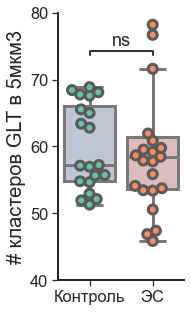

In [97]:
boxplot_fine_view(data=wide_clust.iloc[:, 8:10], 
                    box_pairs=(('clust_quantity_per_125','ctrl'),('clust_quantity_per_125','SE')),
                    ylabel=f'# кластеров {CLUST_PROTEIN} в 5мкм3',
                    ylim=[40, 80], ytick = 10,
                    figname = f'{save_folder}/количество кластеров {CLUST_PROTEIN} с разным объемом boxplot per cell')

Let's compare our samples by the clusters quantity and find that there are no statistical differences.

Then, we calculate median, 25 and 75 percentiles.

In [98]:
percentile_num_clusters = wide_clust.iloc[:, 8:].quantile([0.25, 0.50 , 0.75])
print(percentile_num_clusters)

          clust_quantity_per_125           
exp_group                   ctrl         SE
0.25                   54.770945  53.609180
0.50                   57.181872  58.478708
0.75                   66.066312  61.395988


In [99]:
stat_clust_num, p_clust_num = mannwhitneyu(wide_clust.iloc[:, 8].dropna(), wide_clust.iloc[:, 9].dropna())
print('Statistics=%.3f, p=%.8f' % (stat_clust_num, p_clust_num))

Statistics=237.000, p=0.87424401


Due to the nonparametric Mann-Whitney test, we check whether the clusters quantity after SE differs significantly in comparison to the control. The epilepsy group doesn't demonstrate some differs in comparison to the control group by this parameter.

### Clusters volume fraction(VF)

Then, we should to calculate volume fraction(vf). vf it is a GLT-1 volume occupied by tissue. Firstly, we calculate the sum of volume of all clusters. 

In [100]:
wide_clust [[('sum_volume', 'ctrl'), (('sum_volume', 'SE'))]] = pd.pivot_table(data_clust,
                                                                            index = ['animal_num','slice_num','cell_num'],
                                                                            columns = ['exp_group'],
                                                                            values = ['volume'],
                                                                            aggfunc = 'sum')
wide_clust.head()

volume         surface_area          svr_clust  \
exp_group                        ctrl      SE         ctrl      SE       ctrl   
animal_num slice_num cell_num                                                   
1          1         1         0.3724  0.2550       4.3333  3.2040  11.585260   
                     2         0.3258  0.3040       3.7909  3.6140  11.593853   
           2         1         0.3724  0.2710       4.1128  3.3670  11.010475   
                     2         0.4082  0.2895       4.3992  3.4855  10.798890   
2          1         1         0.2936  0.3010       3.5407  3.6310  12.125590   

                                         clust_quantity          \
exp_group                             SE           ctrl      SE   
animal_num slice_num cell_num                                     
1          1         1         12.569170         3492.0  3794.0   
                     2         11.957143         3297.0  3864.0   
           2         1         12.362676         3185.0  3457.0   
                     2         12.084979         3428.0  3228.0   
2          1         1         11.985281         2644.0  2280.0   

                              clust_quantity_per_125            sum_volume  \
exp_group                                       ctrl         SE       ctrl   
animal_num slice_num cell_num                                                
1          1         1                     68.866735  84.168520  1040.5906   
                     2                     65.021084  85.721444  1116.1329   
           2         1                     62.812299  76.692296   980.1556   
                     2                     67.604572  71.612014  1120.4767   
2          1         1                     52.143083  50.580976   921.2429   

                                          
exp_group                             SE  
animal_num slice_num cell_num             
1          1         1         1580.4646  
                     2         1458.3005  
           2         1         1442.9095  
                     2         1456.4340  
2          1         1          828.6087

Then, we divide sum_volume on total volume to obtain VF

In [101]:
wide_clust [('vf', 'ctrl')] = wide_clust[('sum_volume', 'ctrl')]/tot_vol_df.mean()[0]
wide_clust [('vf', 'SE')] = wide_clust[('sum_volume', 'SE')]/tot_vol_df.mean()[1]
wide_clust.head()

volume         surface_area          svr_clust  \
exp_group                        ctrl      SE         ctrl      SE       ctrl   
animal_num slice_num cell_num                                                   
1          1         1         0.3724  0.2550       4.3333  3.2040  11.585260   
                     2         0.3258  0.3040       3.7909  3.6140  11.593853   
           2         1         0.3724  0.2710       4.1128  3.3670  11.010475   
                     2         0.4082  0.2895       4.3992  3.4855  10.798890   
2          1         1         0.2936  0.3010       3.5407  3.6310  12.125590   

                                         clust_quantity          \
exp_group                             SE           ctrl      SE   
animal_num slice_num cell_num                                     
1          1         1         12.569170         3492.0  3794.0   
                     2         11.957143         3297.0  3864.0   
           2         1         12.362676         3185.0  3457.0   
                     2         12.084979         3428.0  3228.0   
2          1         1         11.985281         2644.0  2280.0   

                              clust_quantity_per_125            sum_volume  \
exp_group                                       ctrl         SE       ctrl   
animal_num slice_num cell_num                                                
1          1         1                     68.866735  84.168520  1040.5906   
                     2                     65.021084  85.721444  1116.1329   
           2         1                     62.812299  76.692296   980.1556   
                     2                     67.604572  71.612014  1120.4767   
2          1         1                     52.143083  50.580976   921.2429   

                                                vf            
exp_group                             SE      ctrl        SE  
animal_num slice_num cell_num                                 
1          1         1         1580.4646  0.164174  0.280496  
                     2         1458.3005  0.176093  0.258815  
           2         1         1442.9095  0.154639  0.256083  
                     2         1456.4340  0.176778  0.258484  
2          1         1          828.6087  0.145345  0.147059

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

('vf', 'ctrl') v.s. ('vf', 'SE'): Mann-Whitney-Wilcoxon test two-sided, P_val=4.009e-01 U_stat=1.950e+02


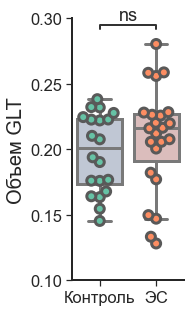

In [102]:
boxplot_fine_view(data=wide_clust.iloc[:, 12:14], 
                    box_pairs=(('vf','ctrl'),('vf','SE')),
                    ylabel=f'Объем {CLUST_PROTEIN}',
                    ylim=[0.1, 0.3], ytick = 0.05,
                    figname = f'{save_folder}/VF {CLUST_PROTEIN} с разным объемом boxplot per cell')

The samples also has no difference in the VF.

## Step 3. GS calculation

Since GS does not aggregates in clusters, we consider using only the volume of the fraction (VF).

### GS volume fraction ctrl vs SE

In [103]:
wide_cell = pd.pivot_table(data_cell,
                        index = ['animal_num','slice_num','cell_num'],
                        columns = ['exp_group'],
                        values = ['volume'],
                        aggfunc = 'sum')
wide_cell = wide_cell.reindex(columns=[('volume','ctrl'),('volume','SE')])
wide_cell.head()

volume          
exp_group                           ctrl        SE
animal_num slice_num cell_num                     
1          1         1         1849.1556   780.819
                     2         2187.8706  1195.229
           2         1         2385.2160   715.855
                     2         3030.0583   640.549
2          1         1         2489.6352  1260.321

In [104]:
tot_vol_df.mean()

TotVol_GLT_ctrl    6338.328691
TotVol_GLT_SE      5634.529420
dtype: float64

In [105]:
wide_cell[('vf','ctrl')] = wide_cell.iloc[:,0]/tot_vol_df.mean()[0]
wide_cell[('vf','SE')] = wide_cell.iloc[:,1]/tot_vol_df.mean()[1]
wide_cell.head()

volume                  vf          
exp_group                           ctrl        SE      ctrl        SE
animal_num slice_num cell_num                                         
1          1         1         1849.1556   780.819  0.291742  0.138577
                     2         2187.8706  1195.229  0.345181  0.212126
           2         1         2385.2160   715.855  0.376316  0.127048
                     2         3030.0583   640.549  0.478053  0.113683
2          1         1         2489.6352  1260.321  0.392790  0.223678

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

('vf', 'ctrl') v.s. ('vf', 'SE'): Mann-Whitney-Wilcoxon test two-sided, P_val=4.558e-03 U_stat=3.470e+02


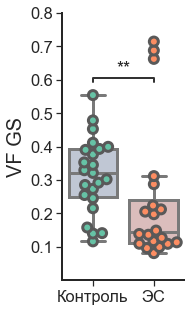

In [106]:
boxplot_fine_view(data=wide_cell.iloc[:,2:4], box_pairs=(('vf', 'ctrl'), ('vf', 'SE')), 
                        ylabel = f'VF {CELL_PROTEIN}', ylim = [0.0001, 0.8],
                        ytick = 0.1, figname= f'VF {CELL_PROTEIN}')

In [107]:
percentile_vf_cell = wide_cell.iloc[:, 2:4].quantile([0.25, 0.50 , 0.75])
print(percentile_vf_cell)

                 vf          
exp_group      ctrl        SE
0.25       0.250281  0.112596
0.50       0.321041  0.143665
0.75       0.391398  0.239636


In [108]:
stat_vf_cell, p_vf_cell= mannwhitneyu(wide_cell.iloc[:, 2].dropna(), wide_cell.iloc[:, 3].dropna())
print('Statistics=%.3f, p=%.8f' % (stat_vf_cell, p_vf_cell))

Statistics=347.000, p=0.00455844


We see that after SE, GS volume fraction decreases significantly.

## Step 4. Save result 

Save obtain statistical criteria to excel file

In [109]:
stat_table_final = pd.DataFrame(data =[(p_clust_num,stat_clust_num), (p_ks_test, stat_ks_test), 
                                        (p_svr_num, stat_svr_num), (p_vf_cell, stat_vf_cell)], 
                                index=['clust_num',' ks_test','svr_num', 'vf_cell'],
                                columns = ['p-value', 'MW(U)'])
stat_table_final

,p-value,MW(U)
clust_num,8.742440e-01,237.000000
ks_test,1.304360e-36,0.036728
svr_num,2.679092e-01,184.000000
vf_cell,4.558439e-03,347.000000


In [110]:
perc_table_final = pd.concat([pd.DataFrame(data = percentile_num_clusters.values, index=[0.25, 0.50, 0.75], columns = ['ctrl', 'SE']), 
           pd.DataFrame(data = percentile_svr_clusters.values, index=[0.25, 0.50, 0.75], columns = ['ctrl', 'SE']),
           pd.DataFrame(data = percentile_vf_cell.values, index=[0.25, 0.50, 0.75], columns = ['ctrl', 'SE'])], 
           axis = 0, keys=['num_clusters', 'svr_clusters', 'vf_cell'])
perc_table_final

ctrl         SE
num_clusters 0.25  54.770945  53.609180
             0.50  57.181872  58.478708
             0.75  66.066312  61.395988
svr_clusters 0.25  10.719648  10.890548
             0.50  10.874891  11.223198
             0.75  11.589557  11.964177
vf_cell      0.25   0.250281   0.112596
             0.50   0.321041   0.143665
             0.75   0.391398   0.239636

In [111]:
with pd.ExcelWriter(f'output_table/final_out_{CELL_PROTEIN}_{CLUST_PROTEIN}.xlsx') as writer:  
    perc_table_final.to_excel(writer, sheet_name='Percentiles', float_format="%.2f")
    stat_table_final.to_excel(writer, sheet_name='P-val, MW(U)', float_format="%.10f")